In [9]:
# -------- cell 1 ----------
# pytorch2.2.0 numpy1.26.4 albumentations2.0.8
import os, random, time, sys, gc
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
sys.path.append(str(Path("D:/LTB/USA_segmentation")))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)
from dataset_dead_tree import DeadTreeDataset, train_tfms, val_tfms, IMG_SIZE

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

In [10]:
# -------- cell 2 ----------
# ==== 配置 ====
ROOT_DIR   = Path("D:/LTB/USA_segmentation")
SEED       = 42
BATCH_SIZE = 2
NUM_EPOCHS = 40
LR         = 1e-3
DEVICE     = "cuda"
NUM_WORKERS = 4
IMG_SIZE   = 512            # 训练时统一裁剪尺寸

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


In [11]:
# 调试块
print("ROOT_DIR =", ROOT_DIR)
rgb_dir = ROOT_DIR / "RGB_images"
print("RGB_images exists?", rgb_dir.exists())
print("Found RGB files:", len(list(rgb_dir.glob("*"))))
print("Example files:", [p.name for p in rgb_dir.glob("*")][:5])


ROOT_DIR = D:\LTB\USA_segmentation
RGB_images exists? True
Found RGB files: 444
Example files: ['RGB_ar037_2019_n_06_04_0.png', 'RGB_ar037_2019_n_07_05_0.png', 'RGB_ar037_2019_n_07_17_1.png', 'RGB_ar037_2019_n_08_14_0.png', 'RGB_ar037_2019_n_13_13_0.png']


In [12]:
# -------- cell 4 ----------

# --- Train / Val 划分 ---
all_stems = sorted([p.name.split("RGB_")[1][:-4]           # 提取 stem
                    for p in (ROOT_DIR/"RGB_images").glob("RGB_*.png")])

random.shuffle(all_stems)
split = int(len(all_stems)*0.8)
train_ids, val_ids = all_stems[:split], all_stems[split:]

train_ds = DeadTreeDataset(train_ids, ROOT_DIR, aug=train_tfms)
val_ds   = DeadTreeDataset(val_ids,   ROOT_DIR, aug=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train: {len(train_ds)} imgs | Val: {len(val_ds)} imgs")



Train: 355 imgs | Val: 89 imgs


In [13]:
# -------- cell 5 ----------
# class DoubleConv(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_c),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_c),
#             nn.ReLU(inplace=True),
#         )
#     def forward(self, x): return self.net(x)

# class UNet(nn.Module):
#     def __init__(self, in_channels=4, out_channels=1, features=[64,128,256,512,1024]):
#         super().__init__()
#         self.downs, self.ups = nn.ModuleList(), nn.ModuleList()
#         # Down
#         for f in features:
#             self.downs.append(DoubleConv(in_channels, f))
#             self.downs.append(nn.MaxPool2d(2))
#             in_channels = f
#         # Up
#         for f in reversed(features):
#             self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
#             self.ups.append(DoubleConv(f*2, f))
#         self.bottleneck = DoubleConv(features[-1], features[-1]*2)
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skips = []
#         for idx, layer in enumerate(self.downs):
#             x = layer(x)
#             if idx % 2 == 0:   # conv block
#                 skips.append(x)
#         x = self.bottleneck(x)
#         skips = skips[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip = skips[idx//2]
#             if x.shape != skip.shape:   # 兼容奇数尺寸
#                 x = F.resize(x, size=skip.shape[2:])
#             x = torch.cat([skip, x], dim=1)
#             x = self.ups[idx+1](x)
#         return self.final_conv(x)

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64,128,256,512,1024]):
        super().__init__()
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()

        # Down path
        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            self.downs.append(nn.MaxPool2d(2))
            in_channels = f

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)  # 1024→2048

        # Up path
        rev_feats = list(reversed(features))
        for f in rev_feats:
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(f*2, f))

        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skips = []
        for idx, layer in enumerate(self.downs):
            x = layer(x)
            if idx % 2 == 0:           # DoubleConv
                skips.append(x)
        x = self.bottleneck(x)
        skips = skips[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skips[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)



In [14]:
# -------- cell 6 ----------
# criterion = nn.BCEWithLogitsLoss()
# metric_iou = BinaryJaccardIndex().to(DEVICE)

# def dice_coeff(pred, target, eps=1e-6):
#     pred = torch.sigmoid(pred)
#     pred = (pred > 0.5).float()
#     inter = (pred*target).sum(dim=(1,2,3))
#     union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
#     dice = (2*inter + eps)/(union + eps)
#     return dice.mean().item()

criterion = nn.BCEWithLogitsLoss()
metric_iou    = BinaryJaccardIndex().to(DEVICE)

def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    num  = 2 * (pred*target).sum(dim=(1,2,3)) + smooth
    den  = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth
    return 1 - (num/den).mean()

def total_loss(pred, target):
    return 0.5*criterion(pred, target) + 0.5*dice_loss(pred, target)

def dice_coeff(pred, target, eps=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred*target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return (2*inter+eps)/(union+eps)

@torch.no_grad()
def visualize_batch(imgs, masks, preds=None, max_n=4):       
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid

    k = min(max_n, imgs.size(0))
    rgb   = imgs[:k, 1:4].cpu()
    gts   = masks[:k].repeat(1, 3, 1, 1).cpu()
    items = [rgb, gts]

    if preds is not None:
        pred_bin = (torch.sigmoid(preds[:k]) > 0.5).float()
        items.append(pred_bin.repeat(1, 3, 1, 1).cpu())

    grid = make_grid(torch.cat(items, dim=0), nrow=k)
    plt.figure(figsize=(3*k, 3*len(items)))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()



In [15]:
# -------- cell 7 ----------
# def train_epoch(model, loader, optimiser):
#     model.train()
#     epoch_loss, epoch_iou, epoch_dice = 0, 0, 0
#     pbar = tqdm(loader, desc="Train", leave=False)
#     for imgs, masks in pbar:
#         imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
#         preds = model(imgs)
#         loss  = criterion(preds, masks)

#         optimiser.zero_grad()
#         loss.backward()
#         optimiser.step()

#         iou  = metric_iou(torch.sigmoid(preds), masks.int())
#         dice = dice_coeff(preds, masks)

#         epoch_loss += loss.item()*imgs.size(0)
#         epoch_iou  += iou.item()*imgs.size(0)
#         epoch_dice += dice*imgs.size(0)
#         pbar.set_postfix(loss=loss.item(), iou=iou.item())
#     n = len(loader.dataset)
#     return epoch_loss/n, epoch_iou/n, epoch_dice/n
scaler = torch.cuda.amp.GradScaler()
def train_epoch(model, loader, optimiser):
    model.train()
    epoch_loss, epoch_iou, epoch_dice = 0,0,0
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        with torch.cuda.amp.autocast():
            preds = model(imgs)
            loss  = total_loss(preds, masks)
            
        optimiser.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

        iou  = metric_iou(torch.sigmoid(preds), masks.int())
        dice = dice_coeff(preds, masks).mean()

        bs = imgs.size(0)
        epoch_loss += loss.item()*bs
        epoch_iou  += iou.item()*bs
        epoch_dice += dice.item()*bs
    n = len(loader.dataset)
    return epoch_loss/n, epoch_iou/n, epoch_dice/n


@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    epoch_loss, epoch_iou, epoch_dice = 0, 0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss  = criterion(preds, masks)
        iou   = metric_iou(torch.sigmoid(preds), masks.int())
        dice = dice_coeff(preds, masks).mean().item()

        epoch_loss += loss.item()*imgs.size(0)
        epoch_iou  += iou.item()*imgs.size(0)
        epoch_dice += dice*imgs.size(0)
    n = len(loader.dataset)
    return epoch_loss/n, epoch_iou/n, epoch_dice/n


C:\Users\MJQ\AppData\Local\Temp\ipykernel_25140\3242311472.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train:   0%|          | 0/178 [00:00<?, ?it/s]C:\Users\MJQ\AppData\Local\Temp\ipykernel_25140\3242311472.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/40] Train L:0.5205 IoU:0.2269 Dice:0.3388 | Val L:3.2976 IoU:0.0337 Dice:0.0890
  ✔️ New best IoU 0.0337


[02/40] Train L:0.3746 IoU:0.2637 Dice:0.3928 | Val L:0.0946 IoU:0.2640 Dice:0.3589
  ✔️ New best IoU 0.2640


[03/40] Train L:0.3401 IoU:0.2931 Dice:0.4326 | Val L:0.1000 IoU:0.2542 Dice:0.3966


[04/40] Train L:0.3247 IoU:0.3137 Dice:0.4540 | Val L:0.0933 IoU:0.3315 Dice:0.4627
  ✔️ New best IoU 0.3315


[05/40] Train L:0.3145 IoU:0.3247 Dice:0.4728 | Val L:0.0832 IoU:0.3276 Dice:0.4376


[06/40] Train L:0.3057 IoU:0.3319 Dice:0.4879 | Val L:0.0851 IoU:0.3205 Dice:0.4380


[07/40] Train L:0.3057 IoU:0.3317 Dice:0.4857 | Val L:0.0910 IoU:0.3440 Dice:0.4779
  ✔️ New best IoU 0.3440


[08/40] Train L:0.3032 IoU:0.3361 Dice:0.4884 | Val L:0.0930 IoU:0.3319 Dice:0.4428


[09/40] Train L:0.2971 IoU:0.3444 Dice:0.4994 | Val L:0.1035 IoU:0.2172 Dice:0.3535


[10/40] Train L:0.2929 IoU:0.3522 Dice:0.5058 | Val L:0.0844 IoU:0.2936 Dice:0.4305


[11/40] Train L:0.2966 IoU:0.3463 Dice:0.5016 | Val L:0.1014 IoU:0.3470 Dice:0.4745
  ✔️ New best IoU 0.3470


[12/40] Train L:0.2929 IoU:0.3522 Dice:0.5067 | Val L:0.0764 IoU:0.3324 Dice:0.4532


[13/40] Train L:0.2915 IoU:0.3550 Dice:0.5091 | Val L:0.0763 IoU:0.3488 Dice:0.4601
  ✔️ New best IoU 0.3488


[14/40] Train L:0.2889 IoU:0.3612 Dice:0.5145 | Val L:0.1022 IoU:0.2282 Dice:0.3536


[15/40] Train L:0.2903 IoU:0.3593 Dice:0.5104 | Val L:0.0802 IoU:0.3624 Dice:0.4994
  ✔️ New best IoU 0.3624


[16/40] Train L:0.2878 IoU:0.3623 Dice:0.5182 | Val L:0.0942 IoU:0.2859 Dice:0.4260


[17/40] Train L:0.2825 IoU:0.3689 Dice:0.5239 | Val L:0.0890 IoU:0.3327 Dice:0.4772


[18/40] Train L:0.2805 IoU:0.3720 Dice:0.5274 | Val L:0.0714 IoU:0.3760 Dice:0.5206
  ✔️ New best IoU 0.3760


[19/40] Train L:0.2833 IoU:0.3704 Dice:0.5227 | Val L:0.0812 IoU:0.3777 Dice:0.5160
  ✔️ New best IoU 0.3777


[20/40] Train L:0.2851 IoU:0.3679 Dice:0.5197 | Val L:0.0869 IoU:0.3035 Dice:0.4405


[21/40] Train L:0.2815 IoU:0.3684 Dice:0.5252 | Val L:0.0957 IoU:0.2737 Dice:0.3973


[22/40] Train L:0.2830 IoU:0.3717 Dice:0.5226 | Val L:0.0857 IoU:0.3670 Dice:0.5022


[23/40] Train L:0.2829 IoU:0.3696 Dice:0.5236 | Val L:0.0739 IoU:0.3799 Dice:0.5154
  ✔️ New best IoU 0.3799


[24/40] Train L:0.2737 IoU:0.3731 Dice:0.5377 | Val L:0.0835 IoU:0.3275 Dice:0.4788


[25/40] Train L:0.2678 IoU:0.3904 Dice:0.5493 | Val L:0.0721 IoU:0.3707 Dice:0.4955


[26/40] Train L:0.2753 IoU:0.3810 Dice:0.5355 | Val L:0.0775 IoU:0.3676 Dice:0.4842


[27/40] Train L:0.2771 IoU:0.3741 Dice:0.5325 | Val L:0.0773 IoU:0.3733 Dice:0.5181


[28/40] Train L:0.2726 IoU:0.3753 Dice:0.5403 | Val L:0.0735 IoU:0.3662 Dice:0.4915


[29/40] Train L:0.2781 IoU:0.3746 Dice:0.5319 | Val L:0.0723 IoU:0.3928 Dice:0.5353
  ✔️ New best IoU 0.3928


[30/40] Train L:0.2709 IoU:0.3829 Dice:0.5446 | Val L:0.0725 IoU:0.3718 Dice:0.4919


[31/40] Train L:0.2741 IoU:0.3816 Dice:0.5378 | Val L:0.0782 IoU:0.3690 Dice:0.5138


[32/40] Train L:0.2659 IoU:0.3948 Dice:0.5523 | Val L:0.0805 IoU:0.3909 Dice:0.5257


[33/40] Train L:0.2715 IoU:0.3849 Dice:0.5425 | Val L:0.0766 IoU:0.3833 Dice:0.5075


[34/40] Train L:0.2653 IoU:0.3920 Dice:0.5515 | Val L:0.0755 IoU:0.3917 Dice:0.5246


[35/40] Train L:0.2672 IoU:0.3898 Dice:0.5485 | Val L:0.0794 IoU:0.3602 Dice:0.5030


[36/40] Train L:0.2562 IoU:0.4079 Dice:0.5663 | Val L:0.0761 IoU:0.3866 Dice:0.5164


[37/40] Train L:0.2526 IoU:0.4168 Dice:0.5717 | Val L:0.0687 IoU:0.3975 Dice:0.5180
  ✔️ New best IoU 0.3975


[38/40] Train L:0.2602 IoU:0.4008 Dice:0.5596 | Val L:0.0722 IoU:0.4075 Dice:0.5443
  ✔️ New best IoU 0.4075


[39/40] Train L:0.2550 IoU:0.4152 Dice:0.5716 | Val L:0.0723 IoU:0.4062 Dice:0.5396


[40/40] Train L:0.2566 IoU:0.4109 Dice:0.5668 | Val L:0.0667 IoU:0.4058 Dice:0.5328


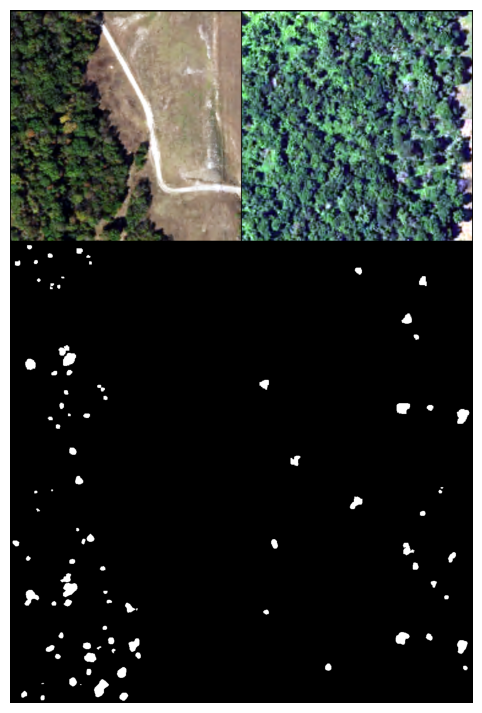

In [16]:
# -------- cell 8 ----------
model = UNet().to(DEVICE)
optimiser = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='max',
                                                 factor=0.5, patience=5)

best_iou = 0
for epoch in range(1, NUM_EPOCHS+1):
    t_loss, t_iou, t_dc = train_epoch(model, train_loader, optimiser)
    v_loss, v_iou, v_dc = eval_epoch(model, val_loader)
    scheduler.step(v_iou)

    print(f"[{epoch:02}/{NUM_EPOCHS}] "
          f"Train L:{t_loss:.4f} IoU:{t_iou:.4f} Dice:{t_dc:.4f} | "
          f"Val L:{v_loss:.4f} IoU:{v_iou:.4f} Dice:{v_dc:.4f}")

    if v_iou > best_iou:
        best_iou = v_iou
        torch.save(model.state_dict(), "best_unet_deep.pth")
        print(f"  ✔️ New best IoU {best_iou:.4f}")

def post_process(pred_mask, min_size=80):
    mask = (pred_mask > 0.5)
    mask = remove_small_objects(mask, min_size=min_size)
    return mask.astype(np.uint8)

# 可视化验证集部分结果
imgs, masks = next(iter(val_loader))
with torch.amp.autocast(device_type="cuda"):
    preds = model(imgs.to(DEVICE))
visualize_batch(imgs, masks, preds)

